In [25]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter
import seaborn as sns


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc,f1_score, precision_score, recall_score
import xgboost as xgb
from xgboost import plot_importance


from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import time
import itertools
import shap
import pickle

from optbinning import OptimalBinning

from sklearn import preprocessing, metrics
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

In [26]:
base_modelo = pd.read_excel("../input/Base_modelo_v2.xlsx")
vars = ["MP_IRV", "AREA_TERRENO_M2","MP_CAT_MPAL", "MP_VALOR_AGREGADO", "nom_mun", "dis_via", "COOR_X", "COOR_Y", "producto", "AHT_PENDIENTE_COD", "AHT_UNIDAD_CLIMATICA", "AHT_VPOTENCIAL", "CLASE_AGR_COD", 'VALOR_M2_TERRENO']
base_modelo_v2 = base_modelo[vars]

categorical_vars = ["MP_CAT_MPAL", "nom_mun", "AHT_PENDIENTE_COD", "AHT_UNIDAD_CLIMATICA", "CLASE_AGR_COD"]

encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(base_modelo_v2[categorical_vars]).toarray()
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_vars))


# Set a threshold for variance (adjust as needed)
threshold = 0.1

# Create a VarianceThreshold instance
variance_filter = VarianceThreshold(threshold=threshold)

# Fit the filter to your data
filtered_data = variance_filter.fit_transform(encoded_df)

In [27]:
# Get the indices of the selected features
selected_features_indices = variance_filter.get_support(indices=True)

# Get the names of the selected features
selected_features = encoded_df.columns[selected_features_indices]

numerical_vars = [x for x in base_modelo_v2.columns if x not in categorical_vars]

base_modelo_v3 = pd.concat([base_modelo_v2[numerical_vars].reset_index(drop = True), \
                               encoded_df[selected_features].reset_index(drop = True)], axis = 1)

df_train, df_test = train_test_split(base_modelo_v3, test_size = .2, random_state = 123) #, stratify = base_modelo_3_v3[['DEPARTAMENTO']]

cols = list(base_modelo_v3.columns)
#cols = [x for x in cols if x != "DEPARTAMENTO"]

df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)    
# df_test.drop(["DEPARTAMENTO"], axis = 1, inplace = True)
# df_train.drop(["DEPARTAMENTO"], axis = 1, inplace = True)


for k, i in enumerate(cols):
    df_test[i] = df_test[i].astype('float')
    df_train[i] = df_train[i].astype('float')

df_train = df_train.fillna(df_train.mean())
df_test = df_test.fillna(df_train.mean())


df_train_v2 = df_train.copy()
df_test_v2 = df_test.copy()    
print(df_train.shape)
print(df_test.shape)


(6859, 24)
(1715, 24)


In [28]:
df_train_v2 = df_train.copy()
df_test_v2 = df_test.copy()  

df_train_v2 = df_train_v2[df_train_v2["VALOR_M2_TERRENO"] <= 400000]
df_test_v2 = df_test_v2[df_test_v2["VALOR_M2_TERRENO"] <= 400000]

print(df_train_v2.shape)
print(df_test_v2.shape)

df_train_v2["LOG_VALOR_M2_TERRENO"] = df_train_v2["VALOR_M2_TERRENO"].apply(np.log)
df_test_v2["LOG_VALOR_M2_TERRENO"] = df_test_v2["VALOR_M2_TERRENO"].apply(np.log)


X_train = df_train_v2.drop(["VALOR_M2_TERRENO", "LOG_VALOR_M2_TERRENO"], axis = 1)
y_train = df_train_v2[["LOG_VALOR_M2_TERRENO"]]
X_test = df_test_v2.drop(["VALOR_M2_TERRENO", "LOG_VALOR_M2_TERRENO"], axis = 1)
y_test = df_test_v2[["LOG_VALOR_M2_TERRENO"]]
interq = 15

rf_regressor = RandomForestRegressor(n_estimators = 150,
                                        #max_features = b,
                                        max_depth = 4, 
                                        min_samples_split = 3, 
                                        min_samples_leaf = 10,
                                        bootstrap = True,
                                    n_jobs = 1,
                                    random_state = 123
                                    )

# xgb_model_fin = xgb.XGBRegressor(colsample_bytree = a,
#                                     gamma = b,
#                                     learning_rate = c,
#                                     max_depth = d,
#                                     n_estimators = e,
#                                     subsample = f,
#                                     reg_alpha = g,
#                                     reg_lambda = h,
#                                     n_jobs = 1,
#                                     random_state = 123
#                                     )
rf_regressor.fit(X_train,
                    y_train)


y_predict_train = rf_regressor.predict(X_train)

differences = [np.exp(real) - np.exp(predicted) for real, predicted in zip(y_train.values, y_predict_train)]
residuals = np.array([float(x) for x in differences])

median_residual = np.median(residuals)
iqr_residual = np.percentile(residuals, 75) - np.percentile(residuals, 25)

# Set a threshold for outliers (e.g., 3 times the IQR)
threshold = interq * iqr_residual

# Create a boolean variable for outliers
outliers = (residuals > threshold) | (residuals < (-threshold))

X_train_v2 = X_train[~outliers]
y_train_v2 = y_train[~outliers]

rf_regressor.fit(X_train_v2, y_train_v2)
#variables
#explainer = shap.TreeExplainer(xgb_model_fin)
#shap_values = explainer.shap_values(x_train)
# explainer = shap.TreeExplainer(rf_regressor, feature_perturbation='interventional')
# shap_values = explainer.shap_values(X_train, approximate=True)
# vals= np.abs(shap_values).mean(0)
# feature_importance_fin = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
# feature_importance_fin.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
# feature_importance_fin_fin=feature_importance_fin[feature_importance_fin['feature_importance_vals']>0]['col_name'].to_list()
#print(i)
#print(feature_importance_fin_fin)
#print(len(feature_importance_fin_fin))
y_predict_test = rf_regressor.predict(X_test)

# Assuming y_pred and y_true are your predicted and actual values
differences = [np.exp(real) - np.exp(predicted) for real, predicted in zip(y_test.values, y_predict_test)]
residuals = np.array([float(x) for x in differences])
    
outliers = (residuals >  threshold) | (residuals < (-threshold))

X_test_v2 = X_test[~outliers]
y_test_v2 = y_test[~outliers]

y_predict_train_v2 = rf_regressor.predict(X_train_v2)
y_predict_test_v2 = rf_regressor.predict(X_test_v2)


#y_train_pred = xgb_model_fin.predict(x_train)
mse_train = np.round(mean_squared_error(np.exp(y_train_v2), np.exp(y_predict_train_v2)), 4)
mae_train = np.round(mean_absolute_error(np.exp(y_train_v2), np.exp(y_predict_train_v2)), 4)
r2_train = np.round(r2_score(np.exp(y_train_v2), np.exp(y_predict_train_v2)), 4)

### medidas sobre el test
#y_val_pred = xgb_model_fin.predict(X_test)
mse_test = np.round(mean_squared_error(np.exp(y_test), np.exp(y_predict_test)), 4)
mae_test = np.round(mean_absolute_error(np.exp(y_test), np.exp(y_predict_test)), 4)
r2_test = np.round(r2_score(np.exp(y_test), np.exp(y_predict_test)), 4)

if (X_test_v2.shape[0] > 0):
    mse_test_v2 = np.round(mean_squared_error(np.exp(y_test_v2), np.exp(y_predict_test_v2)), 4)
    mae_test_v2 = np.round(mean_absolute_error(np.exp(y_test_v2), np.exp(y_predict_test_v2)), 4)
    r2_test_v2 = np.round(r2_score(np.exp(y_test_v2), np.exp(y_predict_test_v2)), 4)
else: 
    mse_test_v2 = np.nan
    mae_test_v2 = np.nan
    r2_test_v2 = np.nan       

(6850, 24)
(1714, 24)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


In [29]:
print(r2_train)
print(r2_test_v2)

0.7429
0.7713


                            col_name  feature_importance_vals
1                    AREA_TERRENO_M2                     1.28
4                             COOR_X                     0.26
6                           producto                     0.04
0                             MP_IRV                     0.04
5                             COOR_Y                     0.04
13                  nom_mun_MONTERÍA                     0.02
21          CLASE_AGR_COD_Clase - VI                     0.02
7                     AHT_VPOTENCIAL                     0.01
19         CLASE_AGR_COD_Clase - III                     0.01
16  AHT_PENDIENTE_COD_Inferiores a 3                     0.01
2                  MP_VALOR_AGREGADO                     0.01
8                      MP_CAT_MPAL_C                     0.00
10                     MP_CAT_MPAL_E                     0.00
3                            dis_via                     0.00
22  CLASE_AGR_COD_Clase - VII o VIII                     0.00
12      

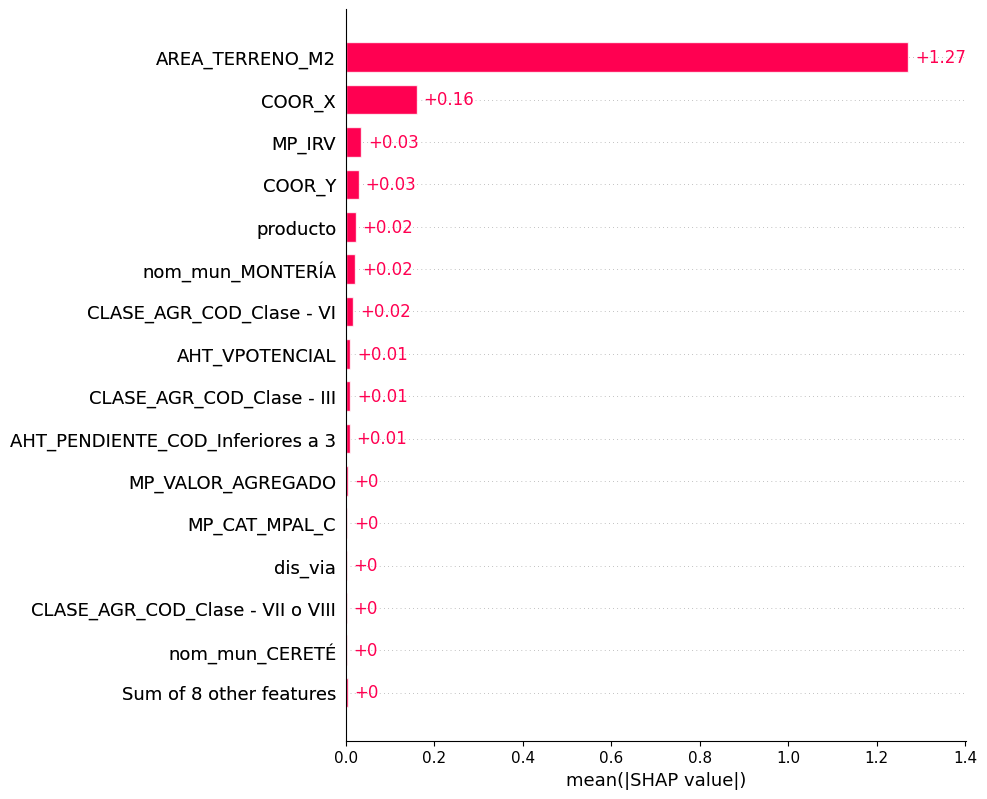

In [30]:
explainer = shap.TreeExplainer(rf_regressor, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_train, approximate=True)
vals= np.abs(shap_values).mean(0)

feature_importance_fin = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance_fin.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
# feature_importance_fin.head(25)

# feature_importance_fin_fin=feature_importance_fin[feature_importance_fin['feature_importance_vals']>0.04]['col_name'].to_list()
# print(feature_importance_fin.head(50))
# feature_importance_fin
# print(feature_importance_fin_fin, len(feature_importance_fin_fin))
print(feature_importance_fin)
shap_values2 = explainer(X_train)
import matplotlib.pyplot as plt

shap.plots.bar(shap_values2, max_display=16)

In [31]:
feature_importance_fin.reset_index(inplace = True, drop = True)
var_list = feature_importance_fin["col_name"].to_list()
var_list

['AREA_TERRENO_M2',
 'COOR_X',
 'producto',
 'MP_IRV',
 'COOR_Y',
 'nom_mun_MONTERÍA',
 'CLASE_AGR_COD_Clase - VI',
 'AHT_VPOTENCIAL',
 'CLASE_AGR_COD_Clase - III',
 'AHT_PENDIENTE_COD_Inferiores a 3',
 'MP_VALOR_AGREGADO',
 'MP_CAT_MPAL_C',
 'MP_CAT_MPAL_E',
 'dis_via',
 'CLASE_AGR_COD_Clase - VII o VIII',
 'nom_mun_CERETÉ',
 'MP_CAT_MPAL_F',
 'MP_CAT_MPAL_D',
 'AHT_UNIDAD_CLIMATICA_CU',
 'CLASE_AGR_COD_Clase - IV',
 'AHT_PENDIENTE_COD_7-12',
 'AHT_PENDIENTE_COD_3-7',
 'AHT_UNIDAD_CLIMATICA_CS']

In [32]:
final_vars = ['AREA_TERRENO_M2',
 'COOR_X',
 'producto',
 'MP_IRV',
 'COOR_Y',
 'nom_mun_MONTERÍA',
 'CLASE_AGR_COD_Clase - VI',
 'AHT_VPOTENCIAL',
 'CLASE_AGR_COD_Clase - III',
 'AHT_PENDIENTE_COD_Inferiores a 3',
 'MP_VALOR_AGREGADO',
 'MP_CAT_MPAL_C',
 'MP_CAT_MPAL_E',
 'dis_via',
 'CLASE_AGR_COD_Clase - VII o VIII',
 'nom_mun_CERETÉ',
 "VALOR_M2_TERRENO"]

# ,
#  'MP_CAT_MPAL_F',
#  'MP_CAT_MPAL_D',
#  'AHT_UNIDAD_CLIMATICA_CU',
#  'CLASE_AGR_COD_Clase - IV',
#  'AHT_PENDIENTE_COD_7-12',
#  'AHT_PENDIENTE_COD_3-7',
#  'AHT_UNIDAD_CLIMATICA_CS',

base_modelo_v4 = base_modelo_v3[final_vars]
#base_modelo_v4['LOG_VALOR_M2_TERRENO'] = base_modelo_v4['VALOR_M2_TERRENO'].apply(np.log)
df_train, df_test = train_test_split(base_modelo_v4, test_size = .2, random_state = 123) #, stratify = base_modelo_3_v3[['DEPARTAMENTO']]

cols = list(base_modelo_v4.columns)
#cols = [x for x in cols if x != "DEPARTAMENTO"]

df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)    
# df_test.drop(["DEPARTAMENTO"], axis = 1, inplace = True)
# df_train.drop(["DEPARTAMENTO"], axis = 1, inplace = True)


for k, i in enumerate(cols):
    df_test[i] = df_test[i].astype('float')
    df_train[i] = df_train[i].astype('float')

df_train = df_train.fillna(df_train.mean())
df_test = df_test.fillna(df_train.mean())

In [33]:
df_train_v2 = df_train.copy()
df_test_v2 = df_test.copy()  
df_train_v2 = df_train_v2[df_train_v2["VALOR_M2_TERRENO"] <= 400000]
df_test_v2 = df_test_v2[df_test_v2["VALOR_M2_TERRENO"] <= 400000]

print(df_train_v2.shape)
print(df_test_v2.shape)

df_train_v2["LOG_VALOR_M2_TERRENO"] = df_train_v2["VALOR_M2_TERRENO"].apply(np.log)
df_test_v2["LOG_VALOR_M2_TERRENO"] = df_test_v2["VALOR_M2_TERRENO"].apply(np.log)


X_train = df_train_v2.drop(["VALOR_M2_TERRENO", "LOG_VALOR_M2_TERRENO"], axis = 1)
y_train = df_train_v2[["LOG_VALOR_M2_TERRENO"]]
X_test = df_test_v2.drop(["VALOR_M2_TERRENO", "LOG_VALOR_M2_TERRENO"], axis = 1)
y_test = df_test_v2[["LOG_VALOR_M2_TERRENO"]]
interq = 15

rf_regressor = RandomForestRegressor(n_estimators = 150,
                                        #max_features = b,
                                        max_depth = 4, 
                                        min_samples_split = 3, 
                                        min_samples_leaf = 10,
                                        bootstrap = True,
                                    n_jobs = 1,
                                    random_state = 123
                                    )

# xgb_model_fin = xgb.XGBRegressor(colsample_bytree = a,
#                                     gamma = b,
#                                     learning_rate = c,
#                                     max_depth = d,
#                                     n_estimators = e,
#                                     subsample = f,
#                                     reg_alpha = g,
#                                     reg_lambda = h,
#                                     n_jobs = 1,
#                                     random_state = 123
#                                     )
rf_regressor.fit(X_train,
                    y_train)


y_predict_train = rf_regressor.predict(X_train)

differences = [np.exp(real) - np.exp(predicted) for real, predicted in zip(y_train.values, y_predict_train)]
residuals = np.array([float(x) for x in differences])

median_residual = np.median(residuals)
iqr_residual = np.percentile(residuals, 75) - np.percentile(residuals, 25)

# Set a threshold for outliers (e.g., 3 times the IQR)
threshold = interq * iqr_residual

# Create a boolean variable for outliers
outliers = (residuals > threshold) | (residuals < (-threshold))

X_train_v2 = X_train[~outliers]
y_train_v2 = y_train[~outliers]

rf_regressor.fit(X_train_v2, y_train_v2)
#variables
#explainer = shap.TreeExplainer(xgb_model_fin)
#shap_values = explainer.shap_values(x_train)
# explainer = shap.TreeExplainer(rf_regressor, feature_perturbation='interventional')
# shap_values = explainer.shap_values(X_train, approximate=True)
# vals= np.abs(shap_values).mean(0)
# feature_importance_fin = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
# feature_importance_fin.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
# feature_importance_fin_fin=feature_importance_fin[feature_importance_fin['feature_importance_vals']>0]['col_name'].to_list()
#print(i)
#print(feature_importance_fin_fin)
#print(len(feature_importance_fin_fin))
y_predict_test = rf_regressor.predict(X_test)

# Assuming y_pred and y_true are your predicted and actual values
differences = [np.exp(real) - np.exp(predicted) for real, predicted in zip(y_test.values, y_predict_test)]
residuals = np.array([float(x) for x in differences])
    
outliers = (residuals >  threshold) | (residuals < (-threshold))

X_test_v2 = X_test[~outliers]
y_test_v2 = y_test[~outliers]

y_predict_train_v2 = rf_regressor.predict(X_train_v2)
y_predict_test_v2 = rf_regressor.predict(X_test_v2)


#y_train_pred = xgb_model_fin.predict(x_train)
mse_train = np.round(mean_squared_error(np.exp(y_train_v2), np.exp(y_predict_train_v2)), 4)
mae_train = np.round(mean_absolute_error(np.exp(y_train_v2), np.exp(y_predict_train_v2)), 4)
r2_train = np.round(r2_score(np.exp(y_train_v2), np.exp(y_predict_train_v2)), 4)

### medidas sobre el test
#y_val_pred = xgb_model_fin.predict(X_test)
mse_test = np.round(mean_squared_error(np.exp(y_test), np.exp(y_predict_test)), 4)
mae_test = np.round(mean_absolute_error(np.exp(y_test), np.exp(y_predict_test)), 4)
r2_test = np.round(r2_score(np.exp(y_test), np.exp(y_predict_test)), 4)

if (X_test_v2.shape[0] > 0):
    mse_test_v2 = np.round(mean_squared_error(np.exp(y_test_v2), np.exp(y_predict_test_v2)), 4)
    mae_test_v2 = np.round(mean_absolute_error(np.exp(y_test_v2), np.exp(y_predict_test_v2)), 4)
    r2_test_v2 = np.round(r2_score(np.exp(y_test_v2), np.exp(y_predict_test_v2)), 4)
else: 
    mse_test_v2 = np.nan
    mae_test_v2 = np.nan
    r2_test_v2 = np.nan    

r2_test_v2   

(6850, 17)
(1714, 17)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


0.7692

In [34]:
pd.options.display.float_format = '{:.2f}'.format

pd.DataFrame({"Muestra": ["Entrenamiento", "Prueba"],
#"RMSE" : [np.sqrt(mse_train), np.sqrt(mse_test_v2)],
"MAE" : [mae_train, mae_test_v2],
"R_squared" : [r2_train, r2_test_v2]})

Muestra     MAE  R_squared
0  Entrenamiento 3743.45       0.74
1         Prueba 3195.70       0.77

In [35]:
X_train.shape

(6850, 16)

In [36]:
y_fin = pd.concat([y_train_v2, y_test_v2], axis = 0)
X_fin = pd.concat([X_train_v2, X_test_v2], axis = 0)

print(X_train_v2.shape)
print(X_test_v2.shape)
print(X_fin.shape)


rf_regressor_v2 = RandomForestRegressor(n_estimators = 150,
                                        #max_features = b,
                                        max_depth = 4, 
                                        min_samples_split = 3, 
                                        min_samples_leaf = 10,
                                        bootstrap = True,
                                    n_jobs = 1,
                                    random_state = 123
                                    )

# xgb_model_fin = xgb.XGBRegressor(colsample_bytree = a,
#                                     gamma = b,
#                                     learning_rate = c,
#                                     max_depth = d,
#                                     n_estimators = e,
#                                     subsample = f,
#                                     reg_alpha = g,
#                                     reg_lambda = h,
#                                     n_jobs = 1,
#                                     random_state = 123
#                                     )
rf_regressor_v2.fit(X_fin,
                    y_fin)

(6188, 16)
(1534, 16)
(7722, 16)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(max_depth=4, min_samples_leaf=10, min_samples_split=3,
                      n_estimators=150, n_jobs=1, random_state=123)

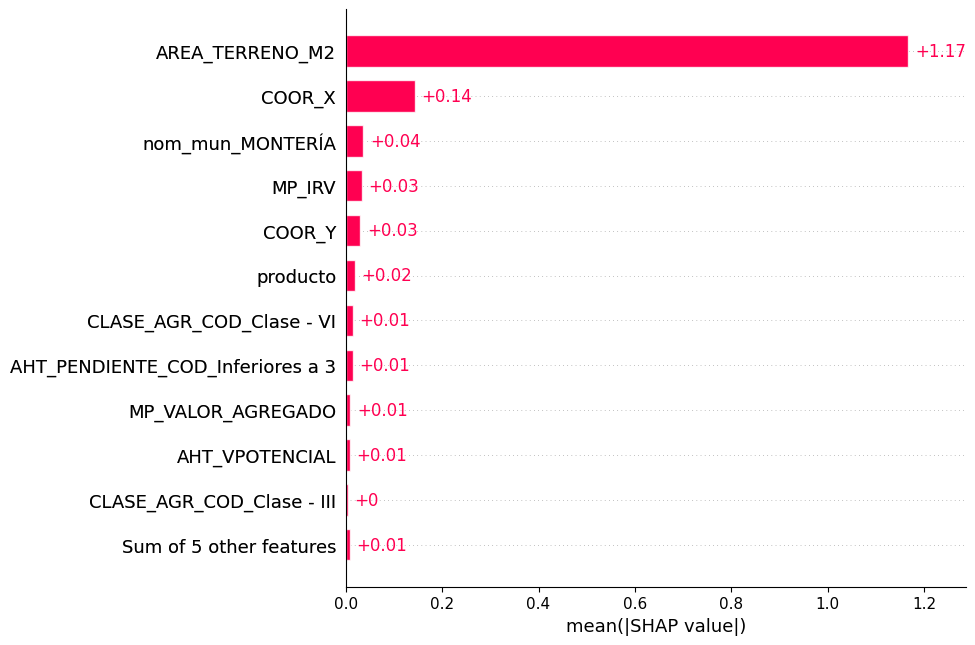

In [39]:
explainer = shap.TreeExplainer(rf_regressor_v2, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_fin, check_additivity=False)
# vals= np.abs(shap_values).mean(0)
# feature_importance_fin = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
# feature_importance_fin.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
# feature_importance_fin.head(25)

# feature_importance_fin_fin=feature_importance_fin[feature_importance_fin['feature_importance_vals']>0.04]['col_name'].to_list()
# print(feature_importance_fin.head(50))
# feature_importance_fin
# print(feature_importance_fin_fin, len(feature_importance_fin_fin))
# print(feature_importance_fin)
shap_values2 = explainer(X_fin, check_additivity=False)
import matplotlib.pyplot as plt

shap.plots.bar(shap_values2, max_display=12)

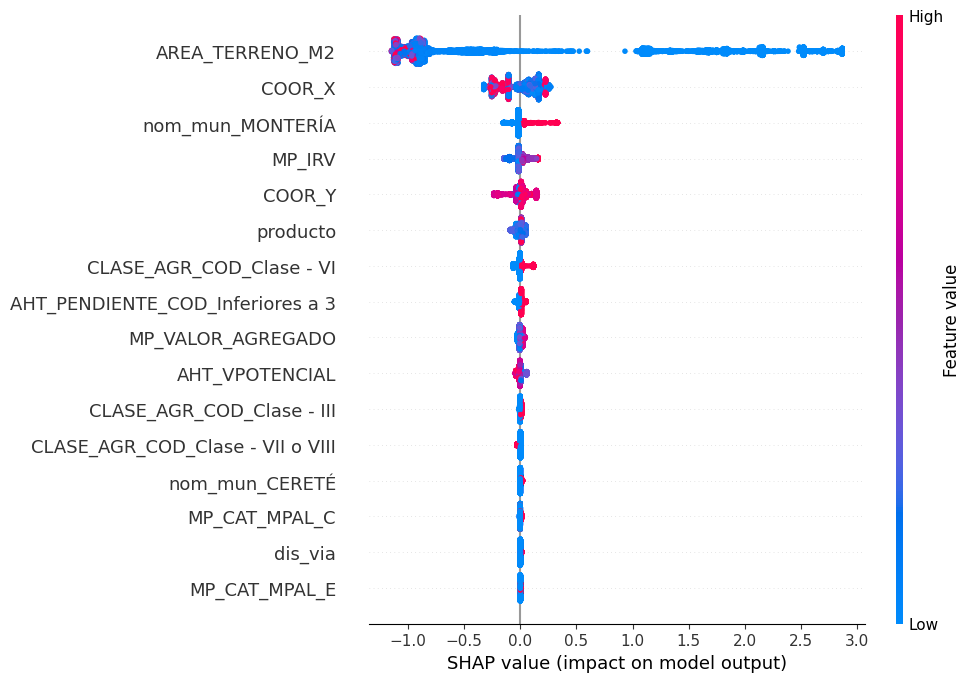

In [40]:
shap.plots.beeswarm(shap_values2, max_display=17)
plt.show()

In [42]:
# Save the model using pickle
with open("../output/MODELO_RF_ARTICULO_49.pkl", "wb") as file:
    pickle.dump(rf_regressor_v2, file)

In [43]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
